# Mismatch analysis tool

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
import pandas as pd
import numpy as np

<Axes: xlabel='Recorded level diff.'>

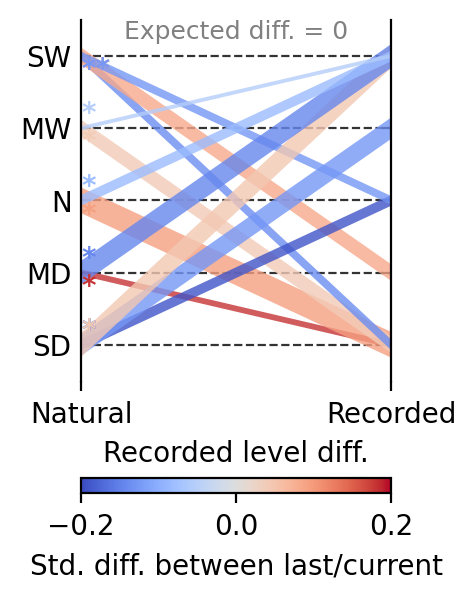

In [2]:
from past1000.utils.plot import plot_mismatch_matrix
from past1000.constants import LEVELS

# 设置随机种子确保结果可重现
np.random.seed(42)

mask = np.array(
    [
        [1, 1, 1, 1, 1],
        [0, 1, 0, 0, 1],
        [1, 0, 1, 0, 1],
        [1, 0, 0, 1, 0],
        [1, 1, 1, 1, 1],
    ]
)

# 生成在 [-0.2, 0.2] 范围内的随机差异值，以匹配 colorbar 范围
diff = (np.random.random((5, 5)) - 0.5) * 0.4  # 范围 [-0.2, 0.2]
diff[~mask.astype(bool)] = np.nan
counts = np.random.randint(1, 15, (5, 5))  # 线条粗细，避免 0
p_values = np.random.random((5, 5)) / 10

plot_mismatch_matrix(
    actual_diff_aligned=pd.DataFrame(diff, index=LEVELS, columns=LEVELS),
    p_value_matrix=pd.DataFrame(p_values, index=LEVELS, columns=LEVELS),
    false_count_matrix=pd.DataFrame(counts, index=LEVELS, columns=LEVELS),
)

## 测试数据

In [3]:
from past1000.calibration import MismatchReport

test_df = pd.DataFrame(
    {
        "value": [0.11, 0.34, 1.10, 0.10, 0.32, 0.33, 3.0, 0.11],
        "classified": [0, 1, 2, -1, 2, 0, 2, 0],
        "expect": [0, 1, 1, 0, 2, 2, 2, 0],
    }
)

mismatch_report = MismatchReport(pred=test_df["expect"], true=test_df["classified"])
mismatch_report

MismatchReport(n_samples=8)

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

true,-2,-1,0,1,2
pred,,,,,
-2,NaN,NaN,NaN,NaN,NaN
-1,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.22,NaN,NaN


<Axes: title={'center': 'False Estimation'}, xlabel='Natural data', ylabel='Historical data'>

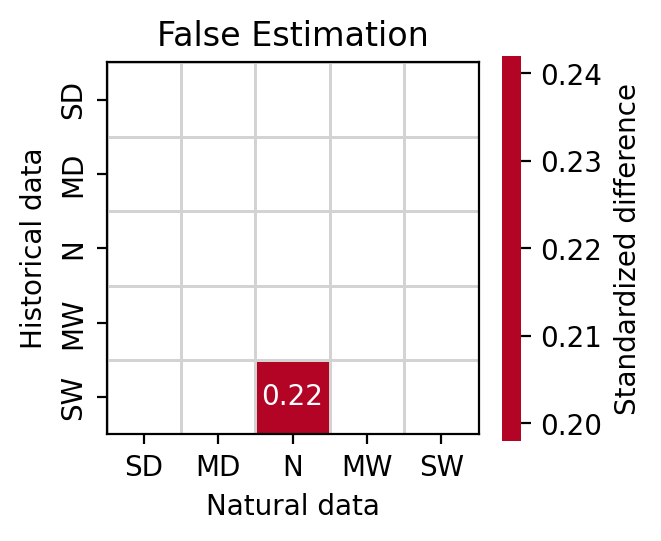

In [4]:
mismatch_report.analyze_error_patterns(value_series=test_df["value"])
mismatch_report.plot_heatmap()

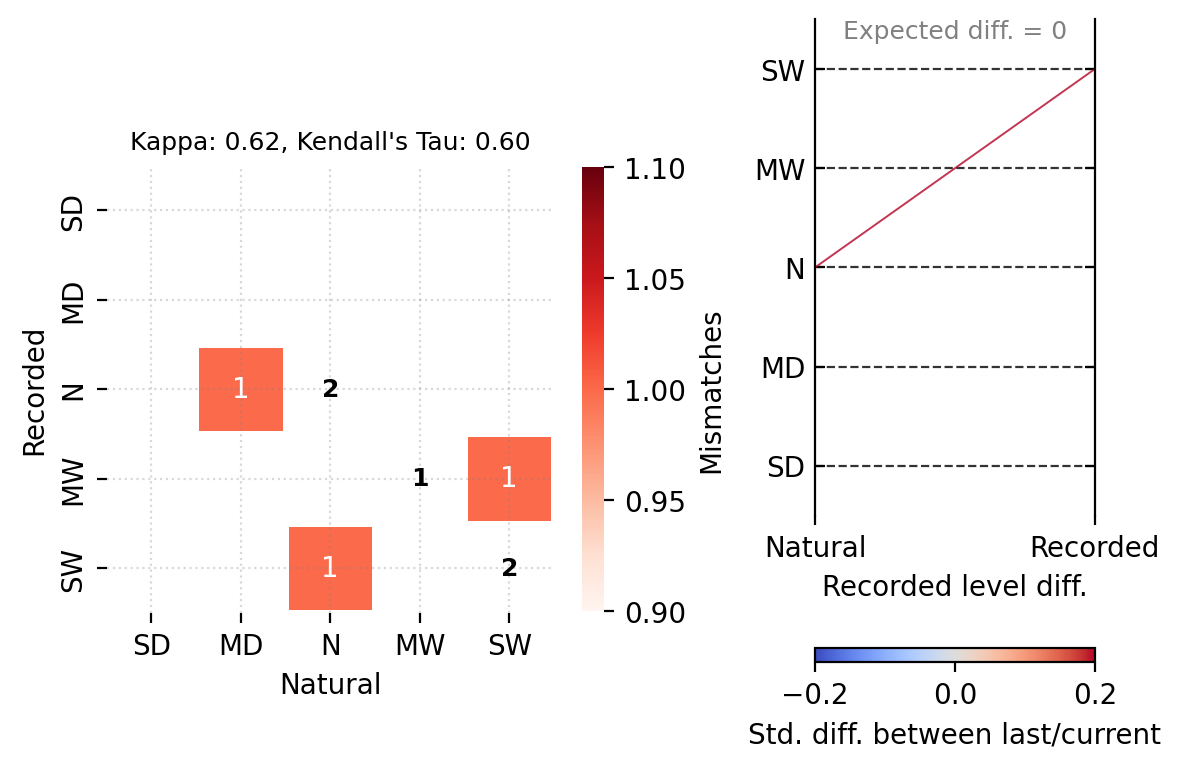

In [5]:
fig = mismatch_report.generate_report_figure()

In [6]:
from past1000.data import load_data
from hydra import compose, initialize
from past1000.mc import combine_reconstructions, plot_combined_reconstruction

with initialize(config_path="../config", version_base=None):
    cfg = compose(config_name="config")

# 加载数据
datasets, uncertainties, history = load_data(cfg)
# 整合树轮数据
combined, _ = combine_reconstructions(
    reconstructions=datasets,
    uncertainties=uncertainties,
    standardize=True,
)

Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 18 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 7 files matching the pattern.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


<Axes: >

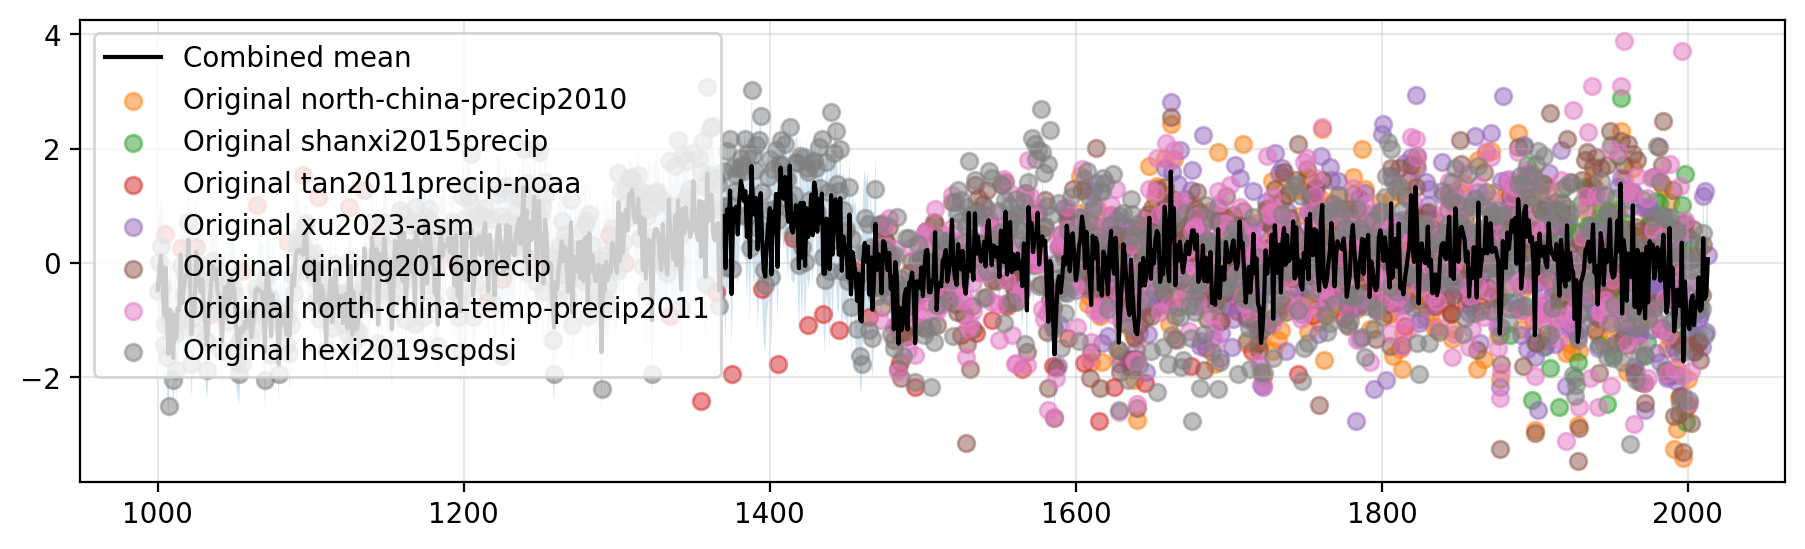

In [7]:
# 绘制整合后的树轮数据
plot_combined_reconstruction(combined, data=datasets)

In [18]:
from past1000.filters import classify
from past1000.calibration import MismatchReport

pred, true = history.aggregate("mean", inplace=True).merge_with(
    combined["mean"],
    time_range=4,
    split=True,
)
mismatch_report = MismatchReport(
    pred=pred,
    true=classify(true),
    value_series=true,
)
mismatch_report

MismatchReport(n_samples=79)

MC模拟:   0%|          | 0/1000 [00:00<?, ?it/s]

true,-2,-1,0,1,2
pred,,,,,
-2,NaN,NaN,NaN,NaN,NaN
-1,0.0335,NaN,0.03425,NaN,NaN
0,NaN,-0.065667,NaN,-0.118,NaN
1,NaN,0.103000,0.16200,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN


<Axes: title={'center': 'False Estimation'}, xlabel='Natural data', ylabel='Historical data'>

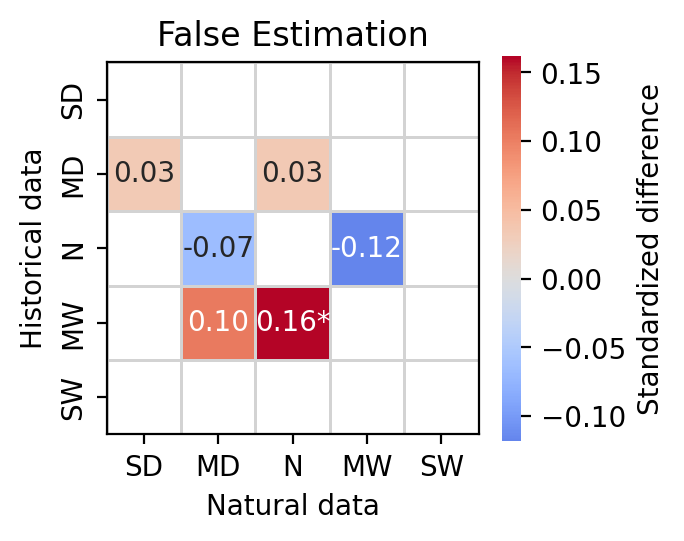

In [19]:
mismatch_report.analyze_error_patterns()
mismatch_report.plot_heatmap()

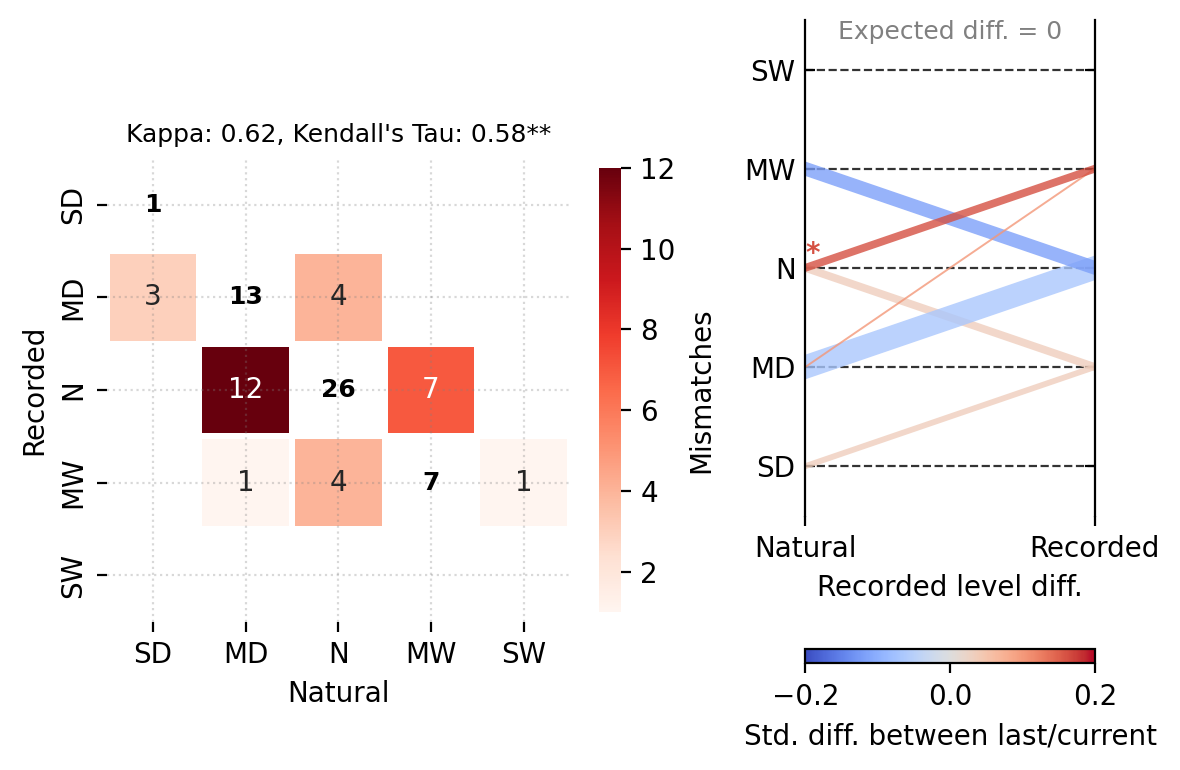

In [20]:
mismatch_report.generate_report_figure();

Figure 1. a: confusion matrix, showing the number of matched (diagonal, white colour) and mismatched (off-diagonal, red colour) judgments of extreme events between natural and recorded levels. b: mismatched between natural and recorded levels. The colour represents the standardised difference between natural and recorded levels. The line width represents the number of mismatches. The line colour represents the standardised difference between this judgement and the previous judgement at the same level. The line transparency represents the significance of the standardised difference (p < 0.05).